In [5]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#adapted from
#https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [6]:
# Load Dataset
ilinet_full = pd.DataFrame(pd.read_csv('ILINet.csv'))
ilinet_full

,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,2004,40,0.982275,0.897159,877,1256,185,3171,1176,353449
1,2004,41,1.018210,1.022480,1071,1373,216,3631,1187,355116
2,2004,42,1.176800,1.062960,1240,1534,226,4019,1267,378094
3,2004,43,1.301210,1.146960,1190,1671,285,4369,1293,380921
4,2004,44,1.277460,1.204950,1327,1718,291,4551,1302,377692
...,...,...,...,...,...,...,...,...,...,...
804,2020,10,5.130780,5.290100,13581,25957,5586,77452,2853,1464094
805,2020,11,5.631160,6.345940,13834,27321,6603,88341,2769,1392087
806,2020,12,6.357030,7.450870,10612,17276,6925,77817,2697,1044402
807,2020,13,5.178310,6.391350,5064,8245,6393,52802,2561,826148


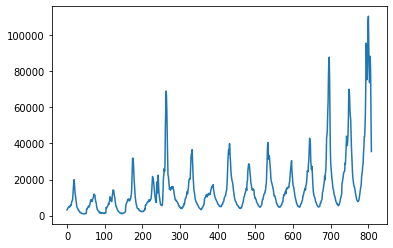

In [7]:
plt.plot(ilinet_full['ILITOTAL'])
plt.show()

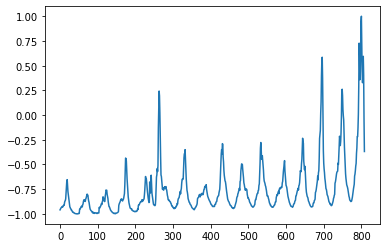

In [8]:
#normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
data=scaler.fit_transform(ilinet_full['ILITOTAL'].values.reshape(-1, 1))
plt.plot(data)

In [9]:
#MMR seasons start and end
end_weeks=ilinet_full.index[ilinet_full['WEEK'] == 39].tolist()
start_weeks=ilinet_full.index[ilinet_full['WEEK'] == 40].tolist()

In [10]:
#729 is the end of the 2018 season
train_data_size = 729

# divide data into training and testing,
train_data =data[0:train_data_size]
test_data =data[train_data_size:]
print(len(train_data))
print(len(test_data))

729
80


In [11]:
#divide data into windows
train_data = torch.FloatTensor(train_data).view(-1)
train_window = 52

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data, train_window)

In [12]:
len(train_inout_seq[1][0])

52

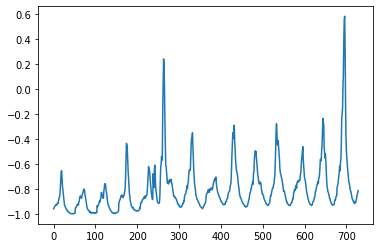

In [23]:
plt.plot(train_data)

In [19]:
#define model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [20]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


# full season predictions from past seasons

In [22]:
epochs = 130#80#150

losses=[]
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        losses.append(single_loss)
        single_loss.backward()
        optimizer.step()
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.02133197
epoch:   1 loss: 0.0213319715


In [42]:
losses=[float(i) for i in losses]

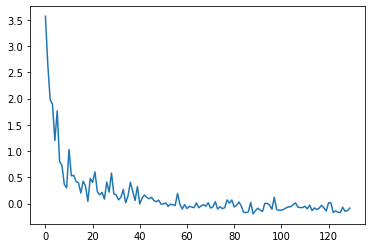

In [43]:
lossperepoch  =[]
c=0
for i in range(0,len(losses),677):
    lossperepoch.append(sum(losses[c*677:c*677+677]))
    c=c+1
plt.plot(range(0,epochs),np.log(lossperepoch))

In [44]:
fut_pred = 52

test_inputs = train_data[-train_window:].tolist()

In [45]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [46]:
actual_predictions = np.array(test_inputs[train_window:])

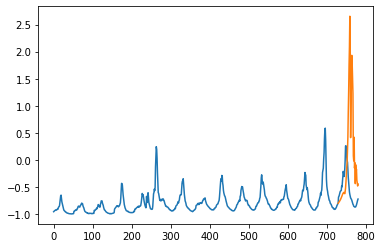

In [47]:
x = np.arange(len(train_data), len(train_data)+52, 1)
plt.plot(data[0:len(train_data)+52])
plt.plot(x,actual_predictions)
plt.show()

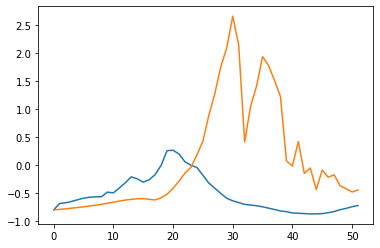

In [48]:
plt.plot(data[len(train_data):len(train_data)+52])
plt.plot(actual_predictions)
plt.show()

Next steps:

- use less training data to predict

- smaller training window (try 10 instead of 52)

- use hopitalization data instread of total case counts (easy change)


# Smaller training window - 10

In [23]:
#smaller training window (try 10 instead of 52)
train_window = 10
train_inout_seq = create_inout_sequences(train_data, train_window)
epochs = 20

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.01729131
epoch:  19 loss: 0.0001483894


In [43]:
fut_pred = 10

test_inputs = train_data[-train_window:].tolist()

[729 730 731 732 733 734 735 736 737 738]


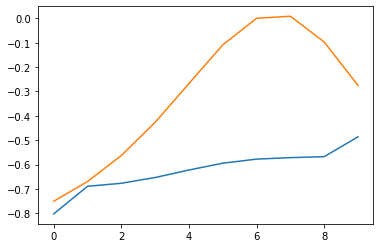

In [44]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(train_data), len(train_data)+10, 1)
print(x)
plt.plot(data[len(train_data):len(train_data)+10])
plt.plot(actual_predictions)
plt.show()

Predictions for smaller training window does not work
- cannot capture time series relationships for this small a window

# Use past two seasons data to predict next 10 weeks


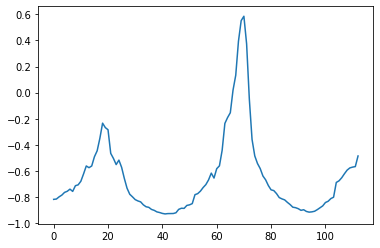

In [58]:
#print(start_weeks)
train_data = data[626:729+10]
train_data = torch.FloatTensor(train_data).view(-1)
train_window = 52
train_inout_seq = create_inout_sequences(train_data, train_window)
plt.plot(train_data)

In [62]:
epochs = 80

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00015252
epoch:  26 loss: 0.00474605
epoch:  51 loss: 0.00001361
epoch:  76 loss: 0.00008023
epoch:  79 loss: 0.0003200193


In [65]:
fut_pred = 10

test_inputs = train_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(train_data), len(train_data)+10, 1)


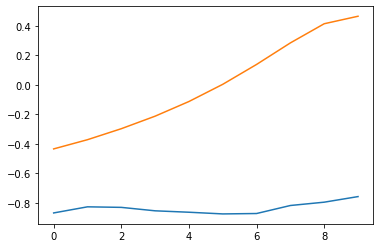

In [66]:
plt.plot(data[len(train_data):len(train_data)+10])
plt.plot(actual_predictions)
plt.show()

Using less training data also gave less accurate predictions for next 10 weeks of current season.

# Use hopitalization data instread of total case counts 
 (reflects the Rona data better)

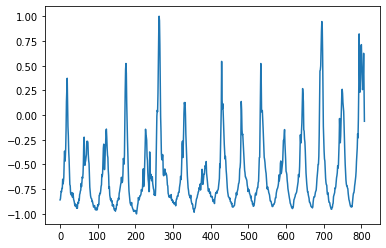

In [67]:
#plt.plot(ilinet_full['% WEIGHTED ILI'].values)
data=scaler.fit_transform(ilinet_full['% WEIGHTED ILI'].values.reshape(-1, 1))
plt.plot(data)

In [68]:
train_data = data[0:729]
train_data = torch.FloatTensor(train_data).view(-1)
train_window = 52
train_inout_seq = create_inout_sequences(train_data, train_window)

In [69]:
epochs = 10

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00017576
epoch:   9 loss: 0.0011247044


In [72]:
fut_pred = 10

test_inputs = train_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(train_data), len(train_data)+10, 1)
#print(x)
#plt.plot(data[0:len(train_data)+10])
#plt.plot(x,actual_predictions)
#plt.show()

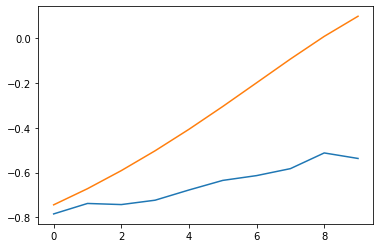

In [73]:
plt.plot(data[len(train_data):len(train_data)+10])
plt.plot(actual_predictions)
plt.show()

 # testing

In [74]:
train_data = data[0:round(len(data)*.7)]
test_data = data[round(len(data)*.7):]
train_data = torch.FloatTensor(train_data).view(-1)
test_data = torch.FloatTensor(test_data).view(-1)
train_window = 52
train_inout_seq = create_inout_sequences(train_data, train_window)


In [75]:
epochs = 25

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00029315
epoch:  24 loss: 0.0001983166


[566 567 568 569 570 571 572 573 574 575]


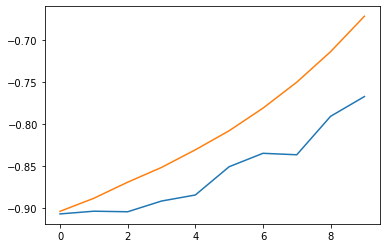

In [76]:
#making predictions on training data
fut_pred = 10

test_inputs = train_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(train_data), len(train_data)+10, 1)
print(x)
plt.plot(data[len(train_data):len(train_data)+10])
plt.plot(actual_predictions)
plt.show()

[243 244 245 246 247 248 249 250 251 252]


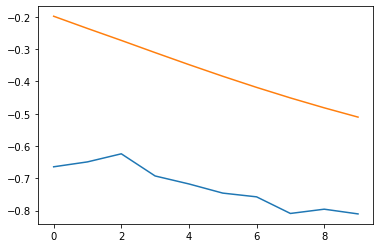

In [77]:
#making predictions on testing data
fut_pred = 10

test_inputs = test_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(test_data), len(test_data)+10, 1)
print(x)
plt.plot(data[len(test_data):len(test_data)+10])
plt.plot(actual_predictions)
plt.show()

 # Conclusions for these steps
 - The LSTM network needs lots of data to make decent predictions for next 10 weeks
 - Was able to predict hospitalization data trend
 - Instead of national data, use state level for more windows to train with
 - try a more sophisticated model - seq2seq

# Using state data

In [14]:
ilinet_full_state = pd.DataFrame(pd.read_csv('ILINet_mod_state.csv'))
ilinet_full_state

,REGION,YEAR,WEEK,%UNWEIGHTED ILI,ILITOTAL
0,Alabama,2010,40,2.13477,249
1,Alaska,2010,40,0.875146,15
2,Arizona,2010,40,0.674721,172
3,Arkansas,2010,40,0.696056,18
4,California,2010,40,1.95412,632
...,...,...,...,...,...
26593,Wisconsin,2020,14,3.45875,467
26594,Wyoming,2020,14,1.67224,10
26595,Puerto Rico,2020,14,0.795229,4
26596,Virgin Islands,2020,14,0.729927,2


In [15]:
#remove missing data
FL=ilinet_full_state.index[ilinet_full_state['REGION'] == 'Florida'].tolist()
ilinet_full_state= ilinet_full_state[~ilinet_full_state.index.isin(FL)]
CM=ilinet_full_state.index[ilinet_full_state['REGION'] == 'Commonwealth of the Northern Mariana Islands'].tolist()
ilinet_full_state= ilinet_full_state[~ilinet_full_state.index.isin(CM)]

In [16]:
#Arrange by state
region_names =ilinet_full_state['REGION'][0:51]#0:51
df = pd.DataFrame(columns = region_names)
for region in region_names:
    indices = ilinet_full_state.index[ilinet_full_state['REGION'] == region].tolist()
    state = ilinet_full_state[ilinet_full_state.index.isin(indices)]["%UNWEIGHTED ILI"].values
    state = [float(i) for i in state]
    df[region]=state

In [17]:
df

REGION,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Georgia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,New York City
0,2.13477,0.875146,0.674721,0.696056,1.95412,0.660684,0.078309,0.100125,2.80877,1.60490,...,0.274655,2.06514,0.747696,1.47641,1.14343,0.510041,1.59741,0.465022,0.632911,1.18222
1,2.05999,1.128270,0.749939,0.674157,2.15266,0.628621,0.238095,0.368550,2.89079,1.71307,...,0.499492,2.09394,0.410939,1.35777,1.23653,1.040070,1.58968,0.581832,0.440621,1.40230
2,1.94224,0.586042,0.953365,0.514217,2.24173,0.804020,0.374158,0.337025,2.41042,2.01249,...,0.499550,2.10072,0.440583,1.48221,1.22545,0.904393,1.52672,1.188220,0.441798,1.29124
3,2.27650,0.967742,0.888804,0.413650,1.91748,0.909658,0.333542,0.460494,3.11632,2.38747,...,0.401638,2.20655,0.755957,1.44393,1.26902,0.955110,1.81171,1.010490,0.490305,1.30236
4,2.83371,0.683851,1.185730,1.090280,2.52326,0.971705,0.396743,0.222332,2.99118,2.65614,...,0.528096,2.36381,0.651859,1.25276,1.26547,0.786370,1.83986,1.096490,0.566636,1.51508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,6.32549,3.702840,2.318160,4.763140,4.11335,5.829790,6.243740,2.467230,2.74144,5.43843,...,5.919210,8.10802,5.696860,3.89315,7.15820,6.853600,5.79525,4.570100,2.172720,4.97021
492,6.10561,3.045440,2.980420,2.576690,4.36857,7.648070,7.018520,2.278940,3.92842,8.07576,...,7.063010,6.97246,5.956540,4.28068,8.19195,6.750790,4.67150,5.722540,2.947000,7.38875
493,6.64586,3.765020,3.754020,2.726850,5.04103,6.940150,7.416960,3.383460,4.89374,9.04217,...,7.431680,8.23540,6.337390,4.81125,7.37984,6.230810,4.10932,6.266750,3.890010,12.21960
494,4.66681,2.679610,3.284730,2.822930,3.75360,4.467750,6.951320,0.595238,5.28330,7.44324,...,6.137820,6.93579,3.719650,5.07139,4.60346,4.048360,2.91321,4.461410,1.437370,14.26240


In [20]:
#create list with all data
data = []
for region in region_names:
    data = data + df[region].values.tolist()

In [21]:
train_data = data[0:round(len(data)*.7)]
test_data = data[round(len(data)*.7):]
train_data = torch.FloatTensor(train_data).view(-1)
test_data = torch.FloatTensor(test_data).view(-1)
train_window = 52
train_inout_seq = create_inout_sequences(train_data, train_window)

In [ ]:
epochs = 25

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.23450743


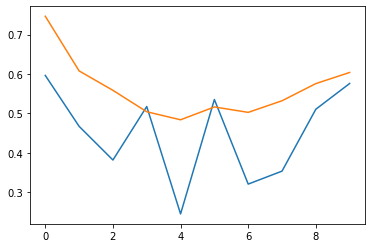

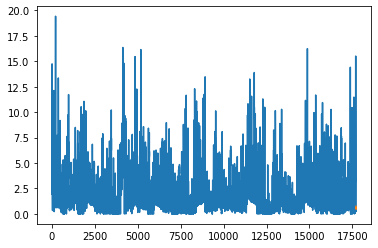

In [149]:
#making predictions on training data
fut_pred = 10

test_inputs = train_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(train_data), len(train_data)+10, 1)

plt.plot(data[len(train_data):len(train_data)+10])
plt.plot(actual_predictions)
plt.show()
#plt.plot(data[0:len(train_data)+10])
#plt.plot(x,actual_predictions)
#plt.show()

# Using first 10 weeks to predict peak intensity

In [21]:
ilinet_full_state = pd.DataFrame(pd.read_csv('ILINet_mod_state.csv'))
#remove missing data
FL=ilinet_full_state.index[ilinet_full_state['REGION'] == 'Florida'].tolist()
ilinet_full_state= ilinet_full_state[~ilinet_full_state.index.isin(FL)]
CM=ilinet_full_state.index[ilinet_full_state['REGION'] == 'Commonwealth of the Northern Mariana Islands'].tolist()
ilinet_full_state= ilinet_full_state[~ilinet_full_state.index.isin(CM)]
ilinet_full_state

,REGION,YEAR,WEEK,%UNWEIGHTED ILI,ILITOTAL
0,Alabama,2010,40,2.13477,249
1,Alaska,2010,40,0.875146,15
2,Arizona,2010,40,0.674721,172
3,Arkansas,2010,40,0.696056,18
4,California,2010,40,1.95412,632
...,...,...,...,...,...
26593,Wisconsin,2020,14,3.45875,467
26594,Wyoming,2020,14,1.67224,10
26595,Puerto Rico,2020,14,0.795229,4
26596,Virgin Islands,2020,14,0.729927,2


In [22]:
#Arrange by state
region_names =ilinet_full_state['REGION'][0:51]#0:51
df = pd.DataFrame(index=range(len(ilinet_full_state)),columns = ilinet_full_state.columns)
c = 0
for region in region_names:
    indices = ilinet_full_state.index[ilinet_full_state['REGION'] == region].tolist()
    state = ilinet_full_state[ilinet_full_state.index.isin(indices)]
    for col in ilinet_full_state.columns:
        df[col][c:c+len(state)] = state[col].values
    c = c+len(state)
df = df[0:25296]
df

,REGION,YEAR,WEEK,%UNWEIGHTED ILI,ILITOTAL
0,Alabama,2010,40,2.13477,249
1,Alabama,2010,41,2.05999,239
2,Alabama,2010,42,1.94224,232
3,Alabama,2010,43,2.2765,274
4,Alabama,2010,44,2.83371,342
...,...,...,...,...,...
25291,New York City,2020,10,4.97021,4546
25292,New York City,2020,11,7.38875,7201
25293,New York City,2020,12,12.2196,9854
25294,New York City,2020,13,14.2624,9867


In [23]:
#scale
vals=[float(i) for i in ilinet_full_state['%UNWEIGHTED ILI'].values]
avg = np.mean(vals)
std = np.std(vals)
#print((vals[0:100]-avg)/std)

In [45]:
# data set with key features
X_data =[]
y_data =[]

for region in region_names:
    
    indices = df.index[df['REGION'] == region].tolist()
    state = df[df.index.isin(indices)]
    
    end_weeks=state.index[state['WEEK'] == 39].tolist()
    
    start_weeks=state.index[state['WEEK'] ==40].tolist() 
    #get a season
    for i in range(len(start_weeks)-1):
        season = df[start_weeks[i]:end_weeks[i]+1]
        
        #extract key features
        first = season['%UNWEIGHTED ILI'][0:10].values #might want to go back and make this >.02
        first=[float(i) for i in first]
        first = (first-avg)/std

        
        peak_intensity=float(season['%UNWEIGHTED ILI'].values.max())
        peak_intensity = (peak_intensity-avg)/std
        
        #wk = season.index[season['%UNWEIGHTED ILI']== season['%UNWEIGHTED ILI'].values.max()]
        #peak_wk=float(season['WEEK'][wk].values)/52
        
        X_data.append(first)
        y_data.append([peak_intensity])
        
X=torch.tensor((X_data[:-1]), dtype=torch.float)
y=torch.tensor((y_data[:-1]), dtype=torch.float)
xPredicted = torch.tensor((X_data[-1]), dtype=torch.float) # 1 X 2 tensor
yTrue = torch.tensor((y_data[-1]), dtype=torch.float)

In [46]:
# scale units
X_max, _ = torch.max(X, 0)
xPredicted_max, _ = torch.max(xPredicted, 0)

X = torch.div(X, X_max)
xPredicted = torch.div(xPredicted, xPredicted_max)

y_max, _ = torch.max(y, 0)
y = torch.div(y, y_max)

In [47]:
print(X.size())
print(y.size())

torch.Size([458, 10])
torch.Size([458, 1])


In [59]:
class Neural_Network(nn.Module):
    def __init__(self, ):
        super(Neural_Network, self).__init__()
        # parameters
        # TODO: parameters can be parameterized instead of declaring them here
        self.inputSize = 10
        self.outputSize = 1
        self.hiddenSize = 10
        
        # weights
        self.W1 = torch.randn(self.inputSize, self.hiddenSize) # 2 X 3 tensor
        self.W2 = torch.randn(self.hiddenSize, self.outputSize) # 3 X 1 tensor
        
    def forward(self, X):
        self.z = torch.matmul(X, self.W1) # 3 X 3 ".dot" does not broadcast in PyTorch
        self.z2 = self.sigmoid(self.z) # activation function
        self.z3 = torch.matmul(self.z2, self.W2)
        o = self.sigmoid(self.z3) # final activation function
        return o
        
    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))
    
    def sigmoidPrime(self, s):
        # derivative of sigmoid
        return s * (1 - s)
    
    def backward(self, X, y, o):
        self.o_error = y - o # error in output
        self.o_delta = self.o_error * self.sigmoidPrime(o) # derivative of sig to error
        self.z2_error = torch.matmul(self.o_delta, torch.t(self.W2))
        self.z2_delta = self.z2_error * self.sigmoidPrime(self.z2)
        self.W1 += torch.matmul(torch.t(X), self.z2_delta)
        self.W2 += torch.matmul(torch.t(self.z2), self.o_delta)
        
    def train(self, X, y):
        # forward + backward pass for training
        o = self.forward(X)
        self.backward(X, y, o)
        
    def saveWeights(self, model):
        # we will use the PyTorch internal storage functions
        torch.save(model, "NN")
        # you can reload model with all the weights and so forth with:
        # torch.load("NN")
        
    def predict(self):
        print ("Predicted data based on trained weights: ")
        print ("Input (scaled): \n" + str(xPredicted))
        print ("Output: \n" + str(self.forward(xPredicted)))
        print("True Value: \n" + str(yTrue))

In [60]:
NN = Neural_Network()
for i in range(1000):  # trains the NN 1,000 times
    #print ("#" + str(i) + " Loss: " + str(torch.mean((y - NN(X))**2).detach().item()))  # mean sum squared loss
    NN.train(X, y)
NN.saveWeights(NN)
NN.predict()

#0 Loss: 0.4220554530620575
#1 Loss: 0.2528141140937805
#2 Loss: 0.2528076171875
#3 Loss: 0.2528001666069031
#4 Loss: 0.2527914047241211
#5 Loss: 0.2527812421321869
#6 Loss: 0.2527690827846527
#7 Loss: 0.2527543008327484
#8 Loss: 0.2527359426021576
#9 Loss: 0.252712607383728
#10 Loss: 0.25268182158470154
#11 Loss: 0.2526392936706543
#12 Loss: 0.25257688760757446
#13 Loss: 0.2524765729904175
#14 Loss: 0.2522905766963959
#15 Loss: 0.2518467605113983
#16 Loss: 0.25001034140586853
#17 Loss: 0.21755075454711914
#18 Loss: 0.3470352590084076
#19 Loss: 0.2337653934955597
#20 Loss: 0.1755964308977127
#21 Loss: 0.1746467798948288
#22 Loss: 0.17357845604419708
#23 Loss: 0.1711663007736206
#24 Loss: 0.17014111578464508
#25 Loss: 0.17009547352790833
#26 Loss: 0.17005707323551178
#27 Loss: 0.17002025246620178
#28 Loss: 0.16998374462127686
#29 Loss: 0.16994689404964447
#30 Loss: 0.16990956664085388
#31 Loss: 0.16987298429012299
#32 Loss: 0.16984032094478607
#33 Loss: 0.16981551051139832
#34 Loss: 0.1

#517 Loss: 0.09995570778846741
#518 Loss: 0.09973033517599106
#519 Loss: 0.09246706962585449
#520 Loss: 0.09037765115499496
#521 Loss: 0.08833901584148407
#522 Loss: 0.08726183325052261
#523 Loss: 0.08569920808076859
#524 Loss: 0.08521971851587296
#525 Loss: 0.08365963399410248
#526 Loss: 0.08350770175457001
#527 Loss: 0.08147753775119781
#528 Loss: 0.08148510754108429
#529 Loss: 0.07920482754707336
#530 Loss: 0.07951326668262482
#531 Loss: 0.0769190862774849
#532 Loss: 0.07725359499454498
#533 Loss: 0.07430170476436615
#534 Loss: 0.0745687410235405
#535 Loss: 0.07127741724252701
#536 Loss: 0.07211483269929886
#537 Loss: 0.06924707442522049
#538 Loss: 0.07160582393407822
#539 Loss: 0.06794217228889465
#540 Loss: 0.0714595764875412
#541 Loss: 0.0648212730884552
#542 Loss: 0.06681187450885773
#543 Loss: 0.061230987310409546
#544 Loss: 0.08390357345342636
#545 Loss: 0.0767253190279007
#546 Loss: 0.07328428328037262
#547 Loss: 0.06835632771253586
#548 Loss: 0.06849884241819382
#549 Loss: 0

#789 Loss: 0.05754571780562401
#790 Loss: 0.057482000440359116
#791 Loss: 0.05839601159095764
#792 Loss: 0.05990900844335556
#793 Loss: 0.06679218262434006
#794 Loss: 0.05787212774157524
#795 Loss: 0.059417787939310074
#796 Loss: 0.05765682831406593
#797 Loss: 0.06064698472619057
#798 Loss: 0.05697476118803024
#799 Loss: 0.059890005737543106
#800 Loss: 0.05637049302458763
#801 Loss: 0.05899353697896004
#802 Loss: 0.05584292486310005
#803 Loss: 0.05820021405816078
#804 Loss: 0.05548004433512688
#805 Loss: 0.05680660903453827
#806 Loss: 0.055314403027296066
#807 Loss: 0.07793814688920975
#808 Loss: 0.0912957563996315
#809 Loss: 0.08894941210746765
#810 Loss: 0.07821832597255707
#811 Loss: 0.07622750103473663
#812 Loss: 0.07413439452648163
#813 Loss: 0.07186762988567352
#814 Loss: 0.06958804279565811
#815 Loss: 0.06753825396299362
#816 Loss: 0.06572548300027847
#817 Loss: 0.06406916677951813
#818 Loss: 0.06255371123552322
#819 Loss: 0.06122733652591705
#820 Loss: 0.06015770137310028
#821 